In [1]:
import numpy as np 
import pandas as pd 
import os, json, re, cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import decimal
import shutil
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Install tqdm if not already installed
%pip install tqdm
from tqdm import tqdm

2024-12-15 04:23:10.250520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-15 04:23:10.545859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-15 04:23:10.545888: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-15 04:23:11.417154: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Configurações
DATASET_PATH = "WaterMeters"

DATA_CSV_PATH = os.path.join(DATASET_PATH, 'data.csv')
IMAGES_FOLDER = os.path.join(DATASET_PATH, "images")
MASK_FOLDER = os.path.join(DATASET_PATH, "masks")
COLLAGE_FOLDER = os.path.join(DATASET_PATH, "collage")
IMAGE_SIZE = (224, 224)  # Tamanho padrão para redes neurais
BATCH_SIZE = 64
EPOCHS = 50

# Configurar seed para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)


In [4]:
def preprocess_image_with_crop(image_path, mask_path, image_size):
    # Verificar se os arquivos existem
    if not os.path.exists(image_path):
        print(f"Aviso: Imagem {image_path} não encontrada.")
        return None
    if not os.path.exists(mask_path):
        print(f"Aviso: Máscara {mask_path} não encontrada.")
        return None

    # Carregar a imagem e a máscara
    img = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Erro ao carregar imagem: {image_path}")
        return None
    if mask is None:
        print(f"Erro ao carregar máscara: {mask_path}")
        return None

    # Aplicar limiarização na máscara para garantir que seja binária
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Aplicar a máscara na imagem para obter a região de interesse
    masked_image = cv2.bitwise_and(img, img, mask=binary_mask)
    
    # Encontrar as coordenadas do retângulo delimitador da máscara
    coords = cv2.findNonZero(binary_mask)  # Encontra os pontos não nulos na máscara
    if coords is None:
        print(f"Aviso: Máscara vazia em {mask_path}.")
        return None
    
    x, y, w, h = cv2.boundingRect(coords)  # Determina o retângulo delimitador
    
    # Cortar a região da imagem correspondente à máscara
    cropped_image = masked_image[y:y+h, x:x+w]

    # Redimensionar a imagem recortada para o tamanho do modelo
    img = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    img = img.astype('float32') / 255.0

    return img


In [5]:
def image_data_generator_with_crop(csv_path, images_folder, masks_folder, image_size, batch_size):
    df = pd.read_csv(csv_path)
    num_samples = len(df)

    all_batches = []

    for offset in range(0, num_samples, batch_size):
        batch_df = df.iloc[offset:offset + batch_size]

        images = []
        values = []

        for _, row in batch_df.iterrows():
            image_path = os.path.join(images_folder, row['photo_name'])
            mask_path = os.path.join(masks_folder, row['photo_name'])
            img = preprocess_image_with_crop(image_path, mask_path, image_size)

            if img is not None:
                images.append(img)
                values.append(row['value'])

        if images:
            all_batches.append((np.array(images), np.array(values)))

    return all_batches

# Criar o gerador
train_gen = image_data_generator_with_crop(DATA_CSV_PATH, IMAGES_FOLDER, MASK_FOLDER, IMAGE_SIZE, BATCH_SIZE)


In [6]:
# Carregar o DataFrame
df = pd.read_csv(DATA_CSV_PATH)

# Escolher uma linha aleatória
random_row = df.sample(1).iloc[0]

# Caminhos da imagem e da máscara
image_path = os.path.join(IMAGES_FOLDER, random_row['photo_name'])
mask_path = os.path.join(MASK_FOLDER, random_row['photo_name'])


In [7]:
# Carregar a imagem e a máscara
img = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Verificar se a imagem e a máscara existem
if img is None:
    print(f"Erro ao carregar a imagem: {image_path}")
elif mask is None:
    print(f"Erro ao carregar a máscara: {mask_path}")
else:
    # Aplicar limiarização na máscara
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Aplicar a máscara na imagem
    masked_image = cv2.bitwise_and(img, img, mask=binary_mask)
    
    # Encontrar as coordenadas do retângulo delimitador
    coords = cv2.findNonZero(binary_mask)
    x, y, w, h = cv2.boundingRect(coords)  # Determina o retângulo delimitador
    
    # Cortar a região da imagem correspondente à máscara
    cropped_img = masked_image[y:y+h, x:x+w]


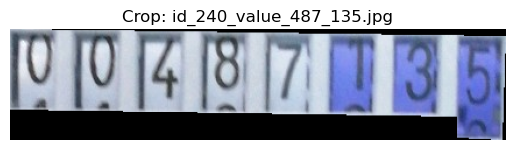

In [11]:
# Exibir a imagem recortada
if 'cropped_img' in locals():
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))  # Converter para RGB
    plt.axis('off')
    plt.title(f"Crop: {random_row['photo_name']}")
    plt.show()


In [12]:
X = []  # Lista para armazenar as imagens processadas
y = []  # Lista para armazenar os valores reais

for _, row in df.iterrows():
    image_path = os.path.join(IMAGES_FOLDER, row['photo_name'])
    mask_path = os.path.join(MASK_FOLDER, row['photo_name'])
    
    # Pré-processar a imagem (crop + resize + normalize)
    cropped_img = preprocess_image_with_crop(image_path, mask_path, IMAGE_SIZE)
    
    if cropped_img is not None:
        X.append(cropped_img)  # Adicionar imagem processada
        y.append(row['value'])  # Adicionar valor real



In [13]:
# Converter listas para arrays
X = np.array(X)
y = np.array(y)

# Verificar formatos
print(f"Formato de X: {X.shape}")  # (n_amostras, altura, largura, canais)
print(f"Formato de y: {y.shape}")  # (n_amostras,)


Formato de X: (1244, 224, 224, 3)
Formato de y: (1244,)


In [14]:
from sklearn.model_selection import train_test_split

# Dividir o conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar tamanhos
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (995, 224, 224, 3), X_test: (249, 224, 224, 3)
y_train: (995,), y_test: (249,)


In [15]:
from tensorflow.keras.applications import ResNet50

model_pre_trained =  ResNet50(
    input_shape = X_train.shape[1:],
    include_top = False,
    weights = 'imagenet',
    classes=1,
    classifier_activation="relu"
)
model_pre_trained.trainable = False

2024-12-15 04:25:26.112465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-15 04:25:26.112953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-15 04:25:26.113087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-15 04:25:26.113180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-15 04:25:26.113265: W tensorflow/c

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

# Modelo pré-treinado ResNet50
model_pre_trained = ResNet50(
    input_shape=X_train.shape[1:],  # X_train precisa ter formato (n, altura, largura, 3)
    include_top=False, #include_top=False é adequada para usar a ResNet50 como extrator de recursos.
    weights='imagenet'
)
model_pre_trained.trainable = False  # Congelar os pesos

# Criar o modelo
model = models.Sequential([
    # Normalização para [-1, 1], compatível com ResNet50
    layers.Rescaling(1. / (255/2), offset=-1, input_shape=X_train.shape[1:]),
    model_pre_trained,  # Extrator de características
    layers.GlobalAveragePooling2D(),  # Redução dimensional após ResNet50
    layers.Dense(1024, activation='relu'),
    layers.Dense(2048, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='relu'),
    layers.Dense(1, activation='relu')  # Saída contínua para regressão
])

# Compilação
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='mae', metrics=['mae'])

# Resumo do modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                        

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stopping: interromper se o modelo não melhorar por 10 épocas consecutivas
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a ser monitorada
    patience=5,         # Número de épocas sem melhoria antes de parar
    restore_best_weights=True  # Restaurar os pesos da melhor época
)

# ReduceLROnPlateau: reduzir a taxa de aprendizado se não houver melhoria
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Métrica a ser monitorada
    factor=0.1,            # Fator de redução da taxa de aprendizado
    patience=5,            # Número de épocas sem melhoria antes de reduzir a LR
    min_lr=1e-6            # Limite inferior para a taxa de aprendizado
)


In [18]:
# Treinar o modelo com callbacks
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],  # Passar os callbacks configurados
    verbose=1
)


Epoch 1/50
13/13 [==============================] - 38s 3s/step - loss: 442.9167 - mae: 442.9167 - val_loss: 314.1066 - val_mae: 314.1066 - lr: 0.0100
Epoch 2/50
13/13 [==============================] - 35s 3s/step - loss: 390.6231 - mae: 390.6231 - val_loss: 225.5072 - val_mae: 225.5072 - lr: 0.0100
Epoch 3/50
13/13 [==============================] - 34s 3s/step - loss: 375.3294 - mae: 375.3294 - val_loss: 254.1003 - val_mae: 254.1003 - lr: 0.0100
Epoch 4/50
13/13 [==============================] - 34s 3s/step - loss: 375.1396 - mae: 375.1396 - val_loss: 219.9575 - val_mae: 219.9575 - lr: 0.0100
Epoch 5/50
13/13 [==============================] - 35s 3s/step - loss: 365.4716 - mae: 365.4716 - val_loss: 265.1793 - val_mae: 265.1793 - lr: 0.0100
Epoch 6/50
13/13 [==============================] - 35s 3s/step - loss: 405.9677 - mae: 405.9677 - val_loss: 240.6820 - val_mae: 240.6820 - lr: 0.0100
Epoch 7/50
13/13 [==============================] - 35s 3s/step - loss: 369.2927 - mae: 369.29

In [19]:
# Descongelar as últimas camadas da ResNet50 para fine-tuning
model_pre_trained.trainable = True

# Congelar camadas anteriores para evitar overfitting
for layer in model_pre_trained.layers[:-10]:  # Manter apenas as 10 últimas camadas treináveis
    layer.trainable = False

from tensorflow.keras.optimizers.legacy import Adam

# Configuração do otimizador legacy
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='mae', metrics=['mae'])



In [20]:
# Continuar o treinamento com camadas descongeladas
history_fine_tuning = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],  # Reutilizar os callbacks
    verbose=1
)

Epoch 1/50
13/13 [==============================] - 41s 3s/step - loss: 619.2328 - mae: 619.2328 - val_loss: 309589.3750 - val_mae: 309589.3750 - lr: 0.0100
Epoch 2/50
13/13 [==============================] - 39s 3s/step - loss: 425.0967 - mae: 425.0967 - val_loss: 3206.6997 - val_mae: 3206.6997 - lr: 0.0100
Epoch 3/50
13/13 [==============================] - 38s 3s/step - loss: 392.9232 - mae: 392.9232 - val_loss: 6670.0356 - val_mae: 6670.0356 - lr: 0.0100
Epoch 4/50
13/13 [==============================] - 38s 3s/step - loss: 369.2451 - mae: 369.2451 - val_loss: 5949.3130 - val_mae: 5949.3130 - lr: 0.0100
Epoch 5/50
13/13 [==============================] - 38s 3s/step - loss: 362.7460 - mae: 362.7460 - val_loss: 4012.4734 - val_mae: 4012.4734 - lr: 0.0100
Epoch 6/50
13/13 [==============================] - 38s 3s/step - loss: 371.8437 - mae: 371.8437 - val_loss: 3034.3315 - val_mae: 3034.3315 - lr: 0.0100
Epoch 7/50
13/13 [==============================] - 38s 3s/step - loss: 367.30

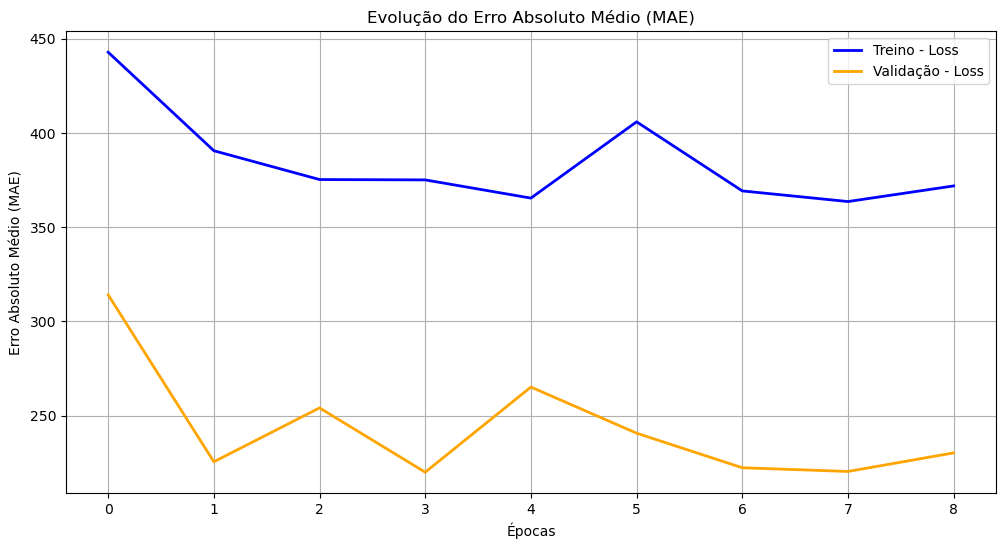

In [21]:
import matplotlib.pyplot as plt

# Plotar o histórico do treinamento
plt.figure(figsize=(12, 6))

# Perda (Loss) no treinamento e validação
plt.plot(history.history['loss'], label='Treino - Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validação - Loss', color='orange', linewidth=2)
plt.title('Evolução do Erro Absoluto Médio (MAE)')
plt.xlabel('Épocas')
plt.ylabel('Erro Absoluto Médio (MAE)')
plt.legend()
plt.grid(True)
plt.show()


8/8 [==============================] - 9s 995ms/step
Imagem 1:
Valor Real: 45693.19, Valor Previsto: 204.22


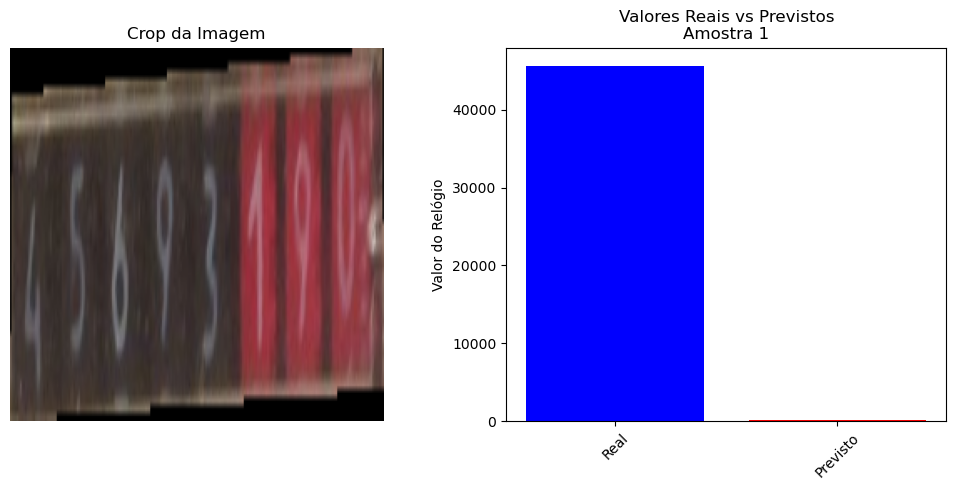

Imagem 2:
Valor Real: 20.09, Valor Previsto: 204.17


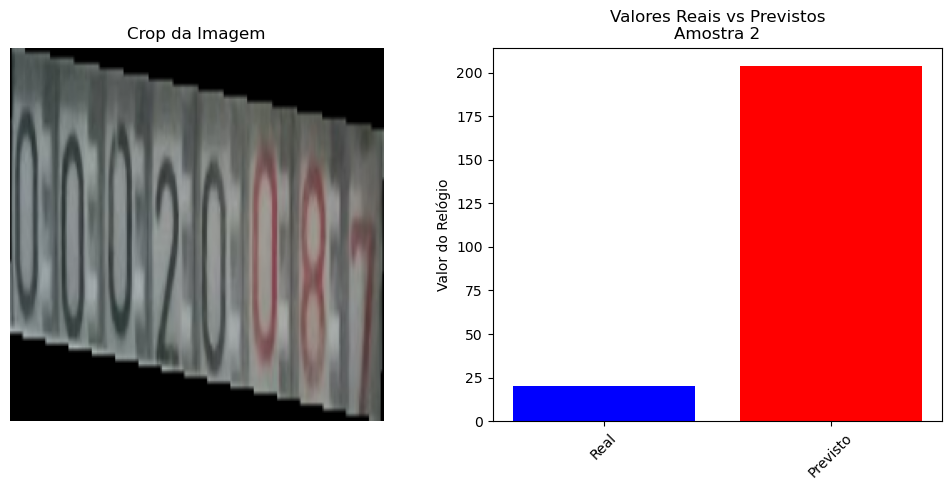

Imagem 3:
Valor Real: 173.65, Valor Previsto: 204.14


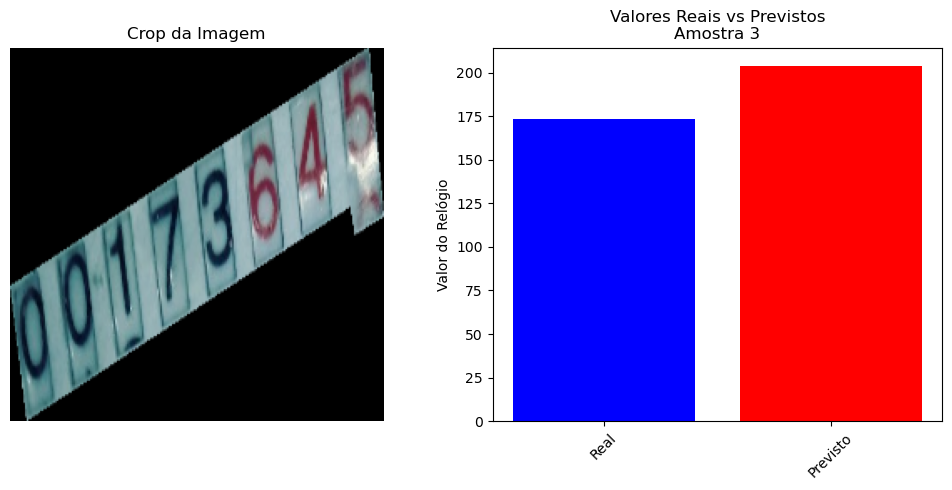

Imagem 4:
Valor Real: 290.43, Valor Previsto: 204.18


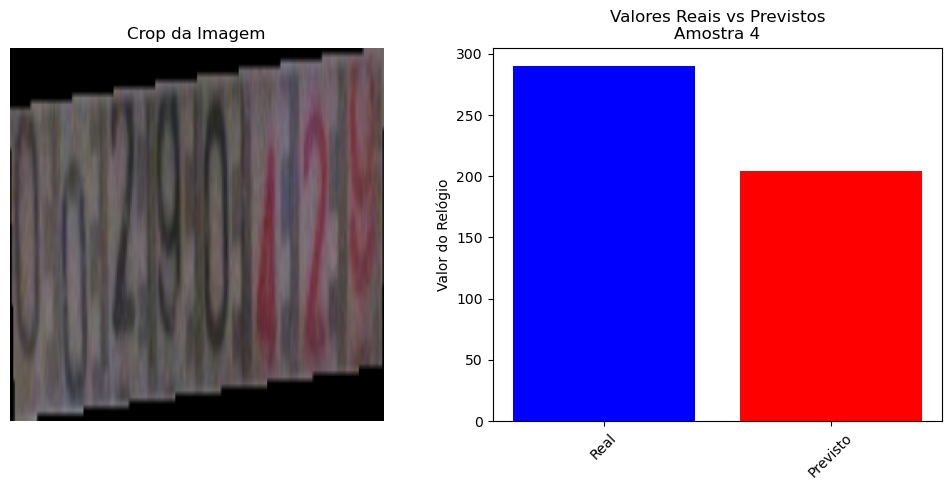

Imagem 5:
Valor Real: 252.13, Valor Previsto: 204.26


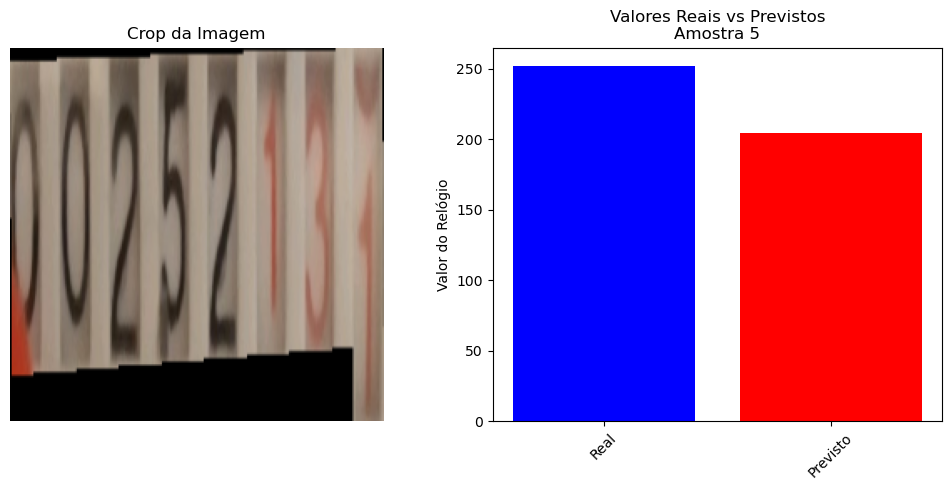

Imagem 6:
Valor Real: 334.98, Valor Previsto: 204.15


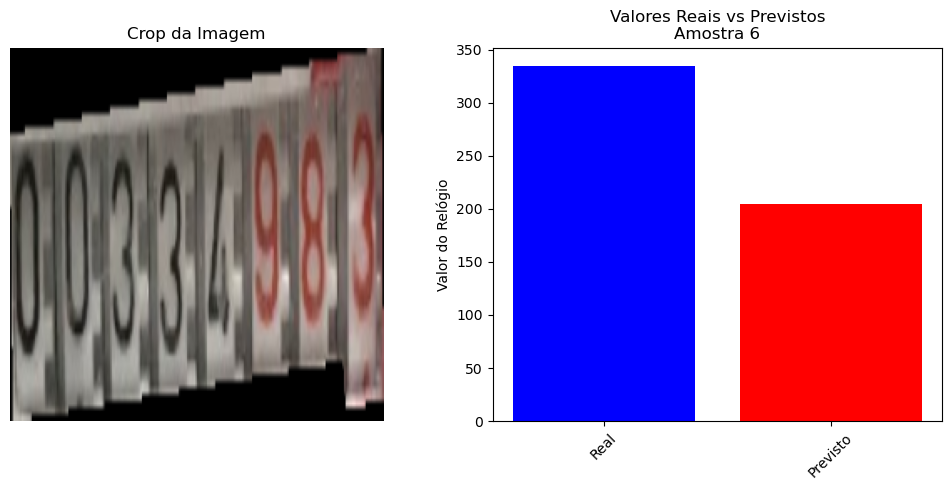

Imagem 7:
Valor Real: 267.62, Valor Previsto: 204.22


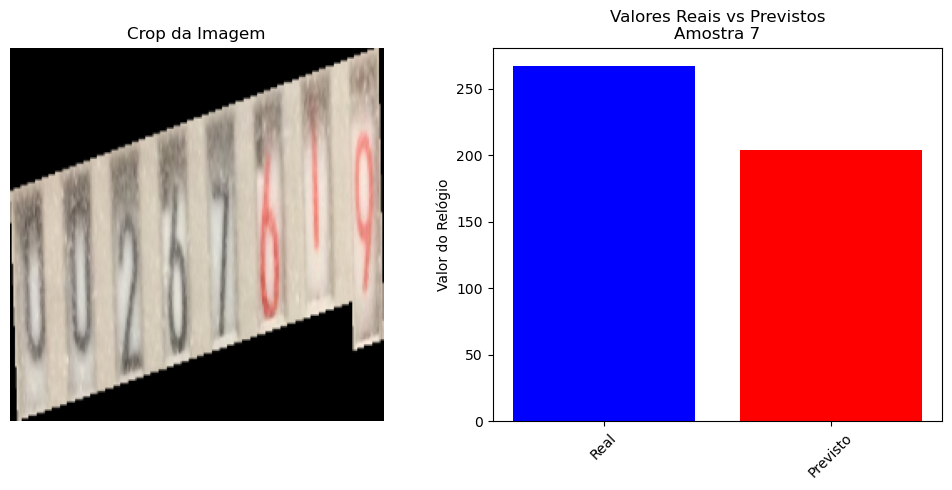

Imagem 8:
Valor Real: 265.05, Valor Previsto: 204.16


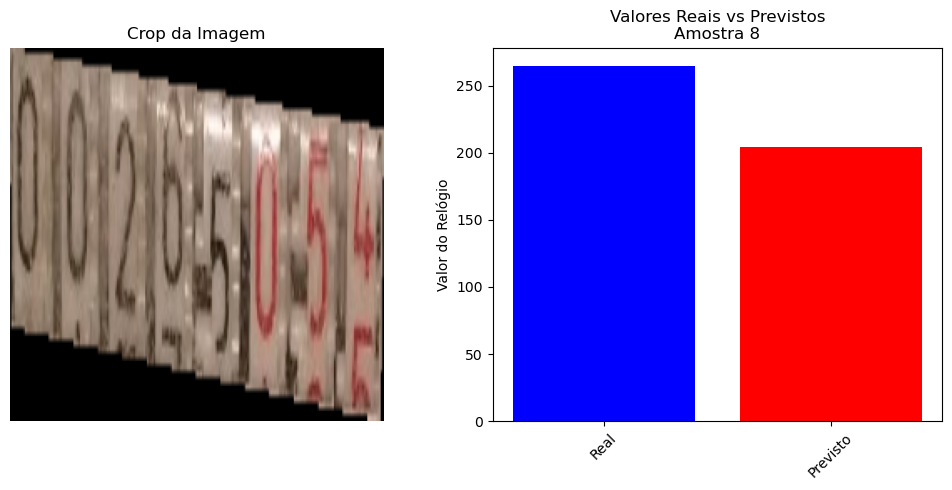

Imagem 9:
Valor Real: 388.23, Valor Previsto: 204.13


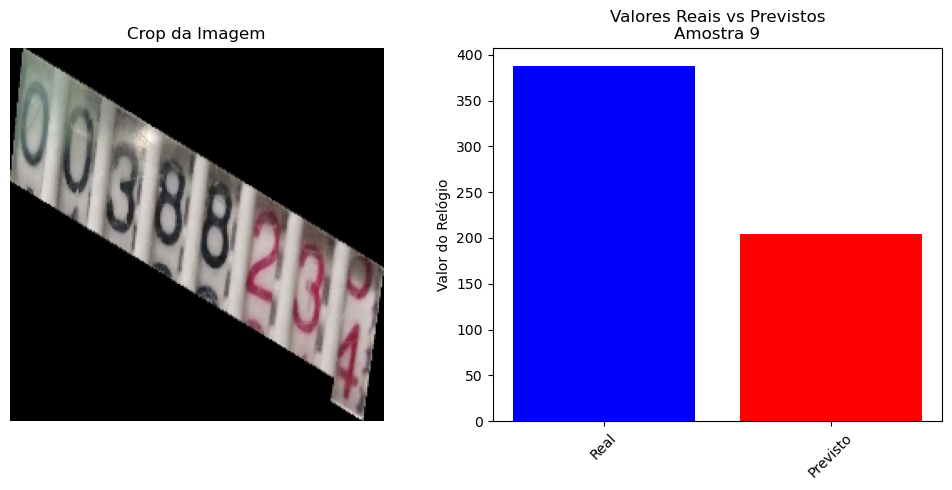

Imagem 10:
Valor Real: 68.01, Valor Previsto: 204.16


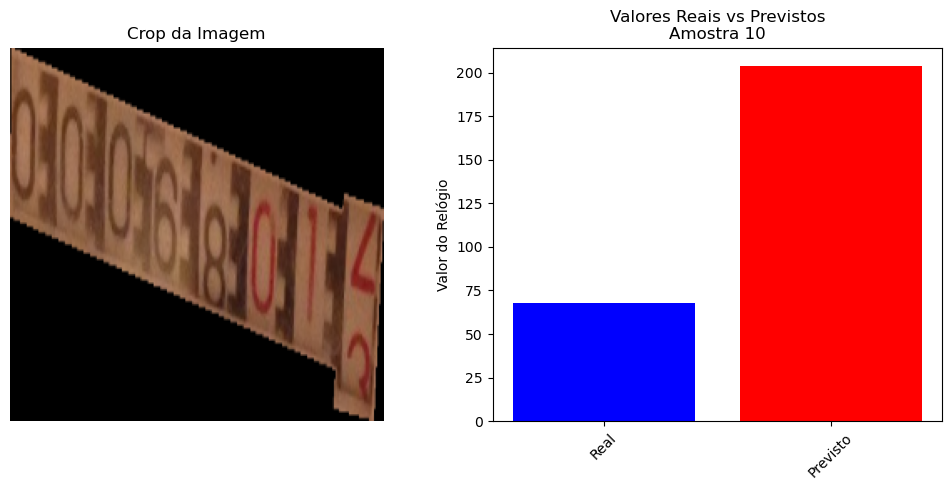

Imagem 11:
Valor Real: 920.05, Valor Previsto: 204.19


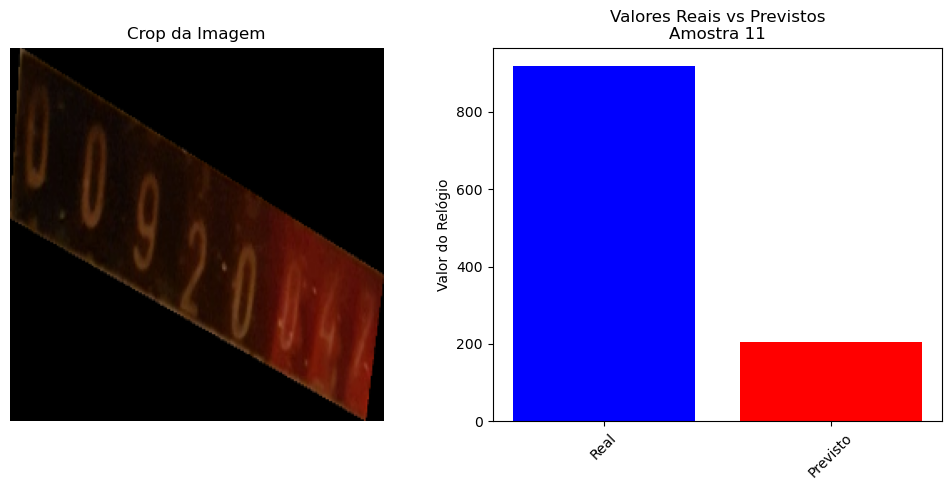

Imagem 12:
Valor Real: 95.22, Valor Previsto: 204.22


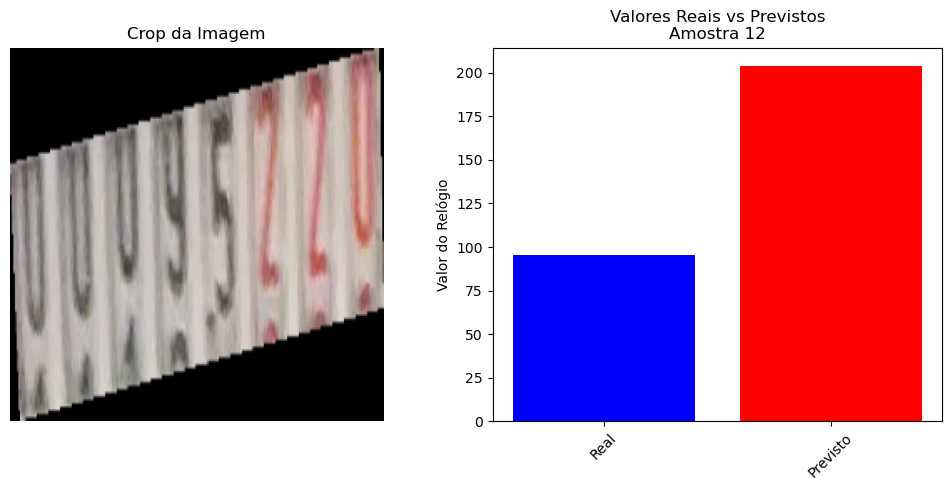

Imagem 13:
Valor Real: 606.36, Valor Previsto: 204.16


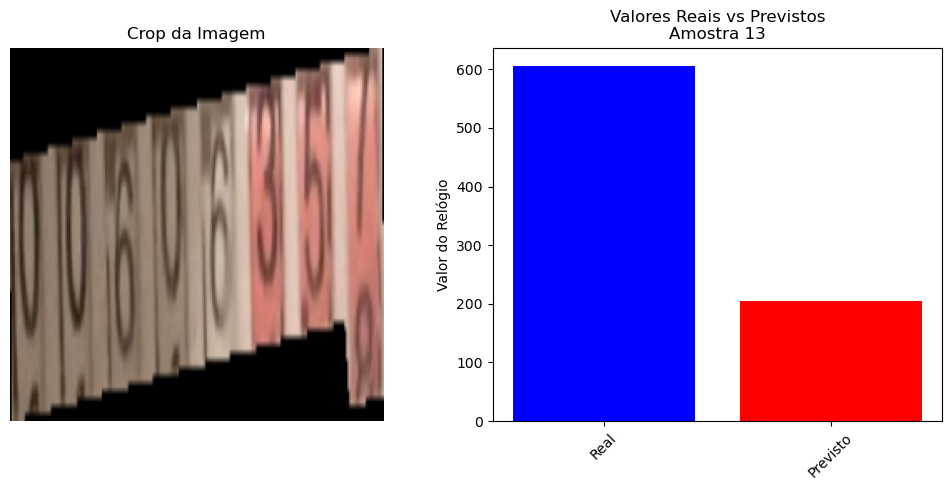

Imagem 14:
Valor Real: 374.66, Valor Previsto: 204.16


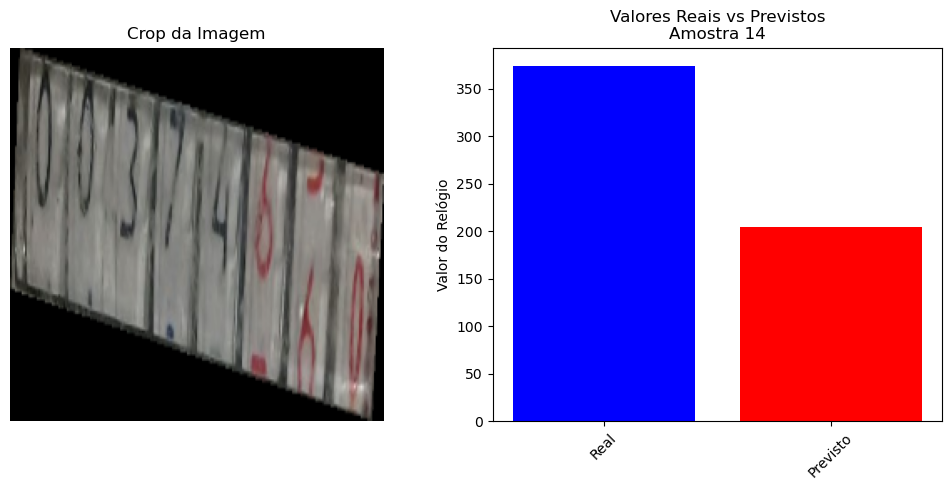

Imagem 15:
Valor Real: 238.48, Valor Previsto: 204.16


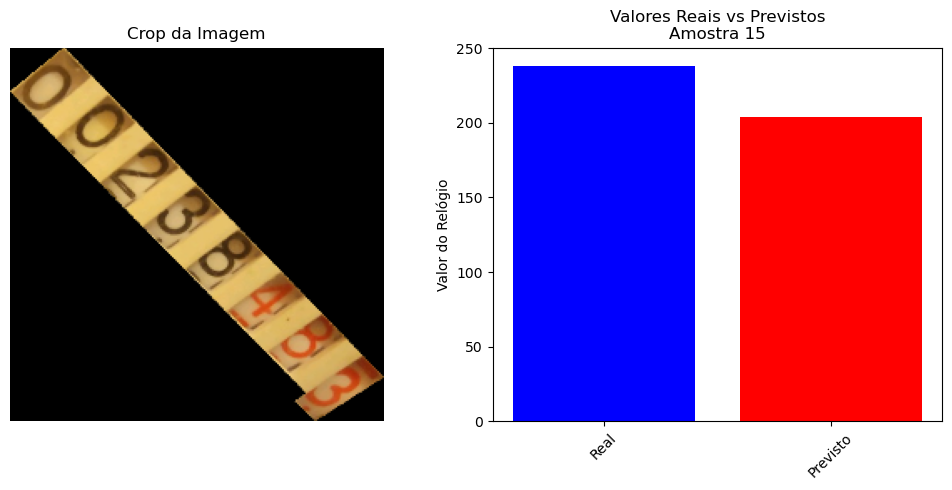

Imagem 16:
Valor Real: 241.66, Valor Previsto: 204.19


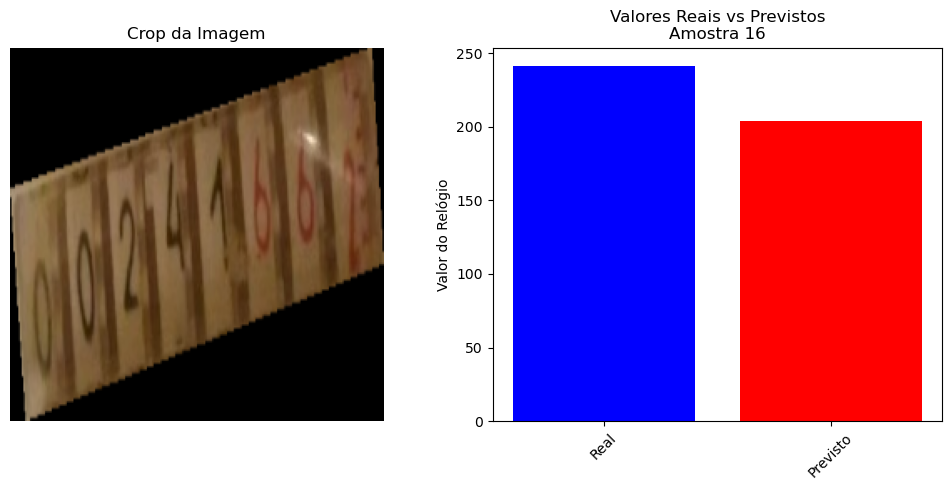

Imagem 17:
Valor Real: 186.11, Valor Previsto: 204.11


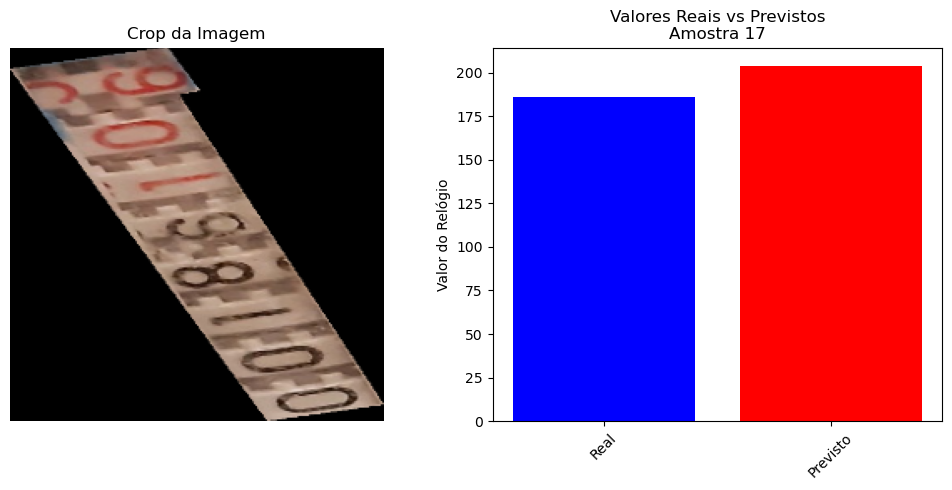

Imagem 18:
Valor Real: 525.56, Valor Previsto: 204.29


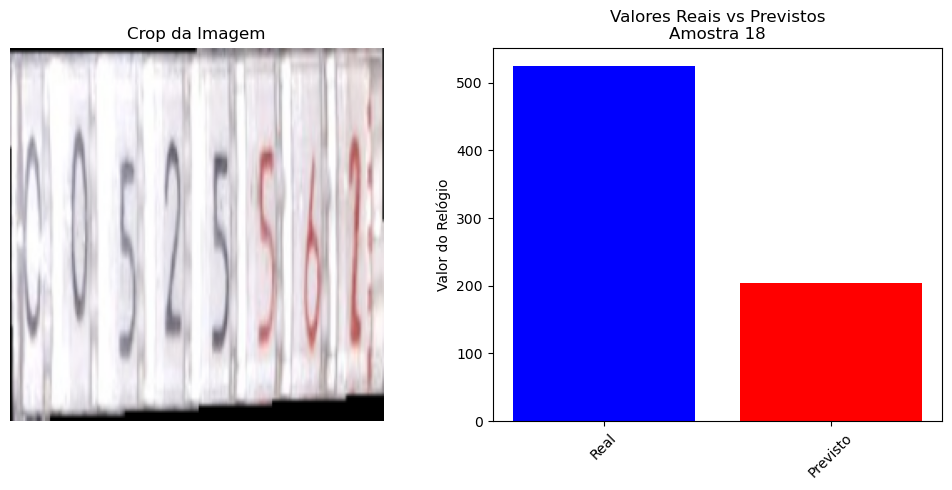

Imagem 19:
Valor Real: 182.69, Valor Previsto: 204.19


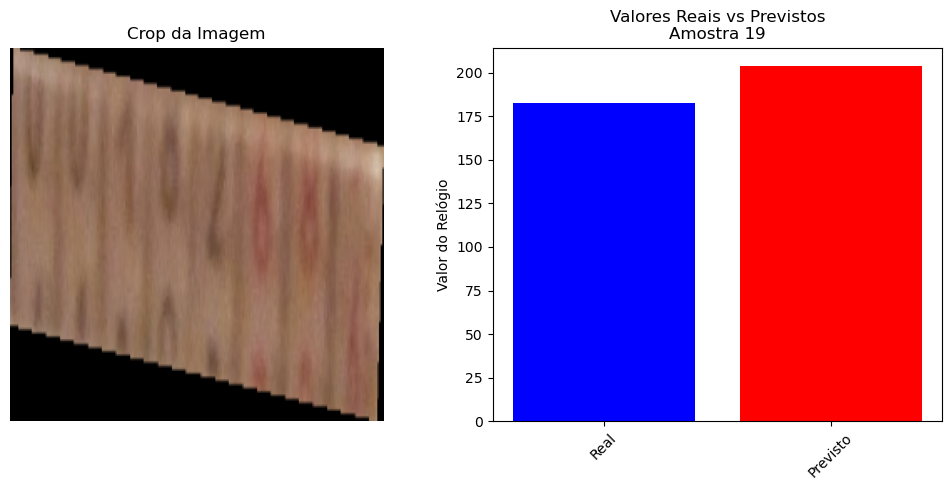

Imagem 20:
Valor Real: 487.13, Valor Previsto: 204.18


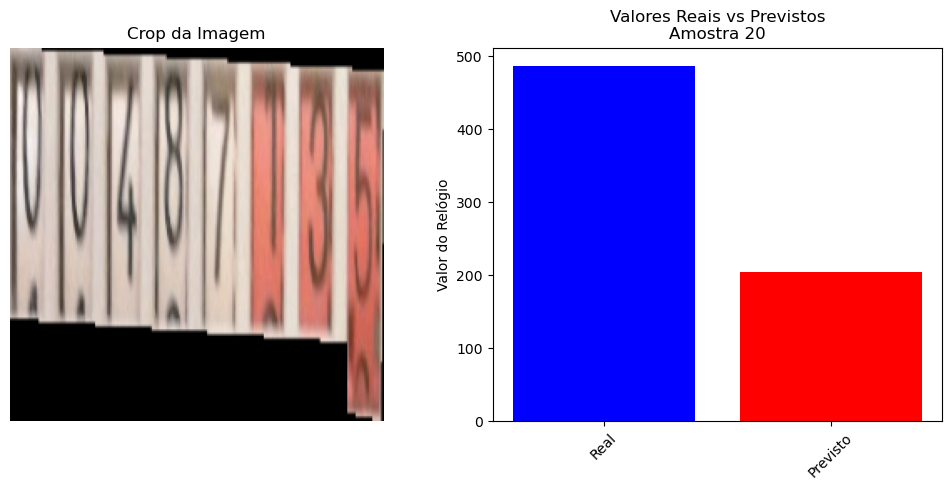

In [22]:
# Fazer predições no conjunto de teste
y_pred = model.predict(X_test)

# Selecionar algumas amostras aleatórias para visualização
num_samples = 20  # Número de amostras para exibir
indices = np.random.choice(len(X_test), num_samples, replace=False)

for i, idx in enumerate(indices):
    # Recuperar o valor real e previsto
    real_value = y_test[idx]
    predicted_value = y_pred[idx][0]
    
    # Recuperar o crop da imagem
    cropped_image = X_test[idx]
    
    # Visualizar o resultado
    plt.figure(figsize=(10, 5))
    
    # Exibir a imagem recortada
    plt.subplot(1, 2, 1)
    plt.imshow(cropped_image)
    plt.axis('off')
    plt.title("Crop da Imagem")
    
    # Exibir os valores reais e previstos
    plt.subplot(1, 2, 2)
    plt.bar(['Real', 'Previsto'], [real_value, predicted_value], color=['blue', 'red'])
    plt.title(f"Valores Reais vs Previstos\nAmostra {i+1}")
    plt.ylabel("Valor do Relógio")
    plt.xticks(rotation=45)
    
    print(f"Imagem {i+1}:")
    print(f"Valor Real: {real_value:.2f}, Valor Previsto: {predicted_value:.2f}")
    
    plt.tight_layout()
    plt.show()
